# KPI Comparison: Original vs Final Proposal
This notebook loads `kpis_subsection_original.json` and `kpis_subsection3.json` and generates comparison bar plots for multiple KPIs (global and per-mode).
Plots are saved to the `plots/` folder and displayed inline.

Requirements: pandas, matplotlib, seaborn. Install if needed: `pip install -r ../requirements.txt` or `pip install pandas matplotlib seaborn`.

In [24]:
# Imports and plotting configuration
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
PLOTS_DIR = Path('plots')
PLOTS_DIR.mkdir(exist_ok=True)
BASE = Path('.')
ORIG_PATH = BASE / 'kpis_subsection_original.json'
PROPOSAL_PATH = BASE / 'kpis_subsection3.json'

In [25]:
# Load KPI JSON files
with open(ORIG_PATH, 'r') as f:
    kpi_orig = json.load(f)
with open(PROPOSAL_PATH, 'r') as f:
    kpi_prop = json.load(f)

# Inspect keys (for quick reference)
list(kpi_orig.keys())

['global_travel_time',
 'per_mode_travel_time',
 'global_waiting_time',
 'per_mode_waiting_time',
 'throughput',
 'stops',
 'emissions']

In [26]:
# Helper: build DataFrames for comparisons
def compare_scalar(key_path_orig, key_path_prop, label, kpi_o=None, kpi_p=None):
    """Return a DataFrame with index ['original','proposal'] and the scalar value."""
    # allow passing kpi dicts or fallback to globals if available
    kpi_o = kpi_o or globals().get('kpi_orig')
    kpi_p = kpi_p or globals().get('kpi_prop')
    if kpi_o is None or kpi_p is None:
        raise NameError('kpi_orig or kpi_prop not loaded. Run the cell that loads the KPI JSONs first.')
    key_path_orig = key_path_orig.split('/')
    key_path_prop = key_path_prop.split('/')
    def get_val(d, path):
        for p in path:
            d = d[p]
        return d
    val_o = get_val(kpi_o, key_path_orig)
    val_p = get_val(kpi_p, key_path_prop)
    return pd.DataFrame({label: [val_o, val_p]}, index=['original', 'proposal'])

def per_mode_df(section, field, kpi_o=None, kpi_p=None):
    # builds DF with index modes and columns ['original','proposal'] for the nested field
    kpi_o = kpi_o or globals().get('kpi_orig')
    kpi_p = kpi_p or globals().get('kpi_prop')
    if kpi_o is None or kpi_p is None:
        raise NameError('kpi_orig or kpi_prop not loaded. Run the cell that loads the KPI JSONs first.')
    # support two patterns: section -> {'per_mode': {...}} OR section -> {mode: {...}}
    def _get_per_mode_dict(kpi, section):
        sec = kpi.get(section)
        if isinstance(sec, dict) and 'per_mode' in sec:
            return sec['per_mode']
        if isinstance(sec, dict):
            return sec
        raise KeyError(f"section '{section}' missing or not dict in KPI file")
    pm_o = _get_per_mode_dict(kpi_o, section)
    pm_p = _get_per_mode_dict(kpi_p, section)
    modes = sorted(set(pm_o.keys()) | set(pm_p.keys()))
    data = {'mode': [] , 'original': [], 'proposal': []}
    for m in modes:
        data['mode'].append(m)
        o_entry = pm_o.get(m, None)
        p_entry = pm_p.get(m, None)
        # if entry is dict, extract the field, else assume scalar
        orig_val = o_entry.get(field) if isinstance(o_entry, dict) else o_entry
        prop_val = p_entry.get(field) if isinstance(p_entry, dict) else p_entry
        data['original'].append(orig_val)
        data['proposal'].append(prop_val)
    return pd.DataFrame(data).set_index('mode')

In [27]:
# Plotting helper for simple two-bar comparison
def plot_comparison(df, title, ylabel, fname, rotate_xticks=False, figsize=(6,4)):
    # plot without legend by default
    ax = df.plot(kind='bar', rot=45 if rotate_xticks else 0, figsize=figsize, legend=False)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    # color proposal bars orange, original bars default blue
    cols = list(df.columns)
    idx = list(df.index)
    n_idx = len(idx)
    # patches are ordered by column (for each column all index bars), so patch_i = col_i * n_idx + row_i
    for col_i, col in enumerate(cols):
        for row_i, row in enumerate(idx):
            patch_i = col_i * n_idx + row_i
            try:
                p = ax.patches[patch_i]
            except IndexError:
                continue
            # if this is the proposal column, color orange; if single-column with proposal index, color that bar orange
            if col == 'proposal' or (len(cols) == 1 and row == 'proposal'):
                p.set_facecolor('orange')
            else:
                p.set_facecolor('#1f77b4')
    plt.tight_layout()
    out = PLOTS_DIR / fname
    plt.savefig(out, dpi=150)
    display(plt.gcf())
    plt.close()

## 1) Average Global Travel Time (mean_s)

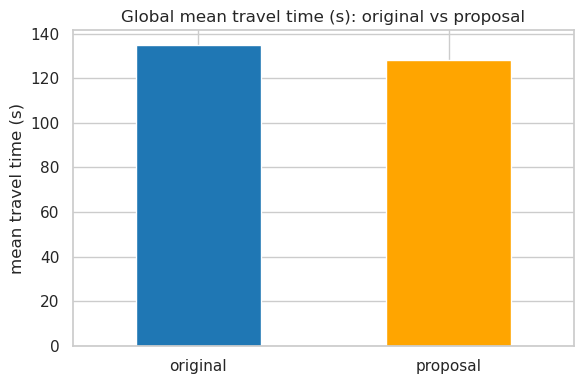

In [28]:
df = compare_scalar('global_travel_time/mean_s', 'global_travel_time/mean_s', 'mean_travel_time_s')
plot_comparison(df, 'Global mean travel time (s): original vs proposal', 'mean travel time (s)', 'global_mean_travel_time.png')

## 2) Average Travel Time by Mode (mean_s)

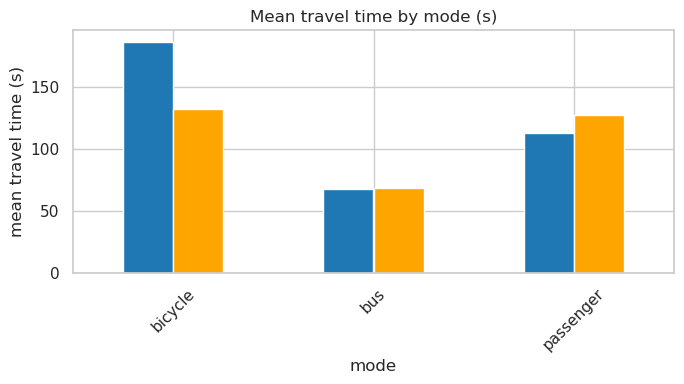

In [29]:
df_modes = per_mode_df('per_mode_travel_time', 'mean_s')
plot_comparison(df_modes, 'Mean travel time by mode (s)', 'mean travel time (s)', 'per_mode_mean_travel_time.png', rotate_xticks=True, figsize=(7,4))

## 3) Average Global Waiting Time (mean_s)

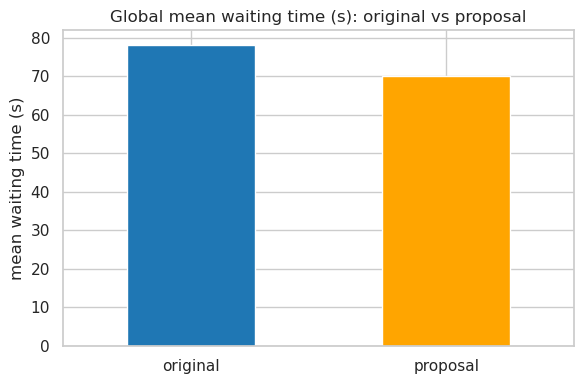

In [30]:
df_wait = compare_scalar('global_waiting_time/mean_s', 'global_waiting_time/mean_s', 'mean_waiting_time_s')
plot_comparison(df_wait, 'Global mean waiting time (s): original vs proposal', 'mean waiting time (s)', 'global_mean_waiting_time.png')

## 4) Average Waiting Time by Mode (mean_s)

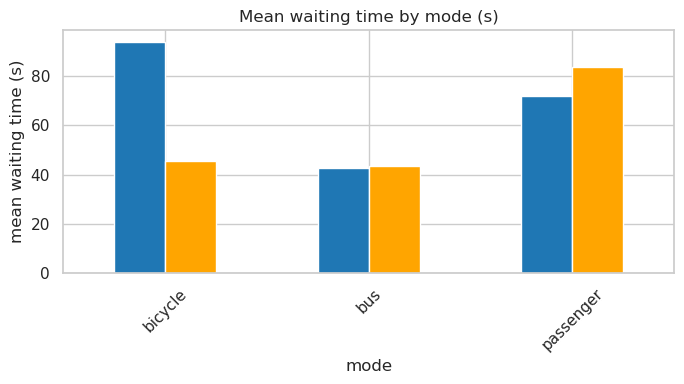

In [31]:
df_wait_modes = per_mode_df('per_mode_waiting_time', 'mean_s')
plot_comparison(df_wait_modes, 'Mean waiting time by mode (s)', 'mean waiting time (s)', 'per_mode_mean_waiting_time.png', rotate_xticks=True, figsize=(7,4))

## 5) Throughput (global and per-mode)

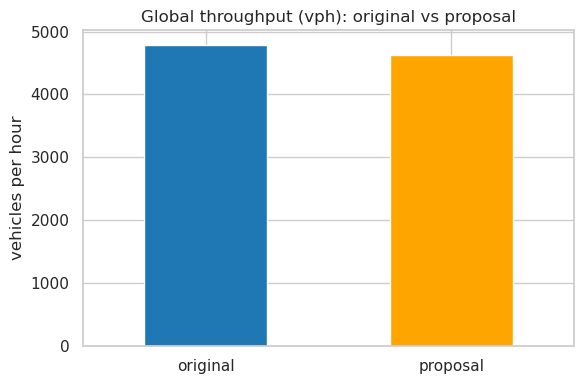

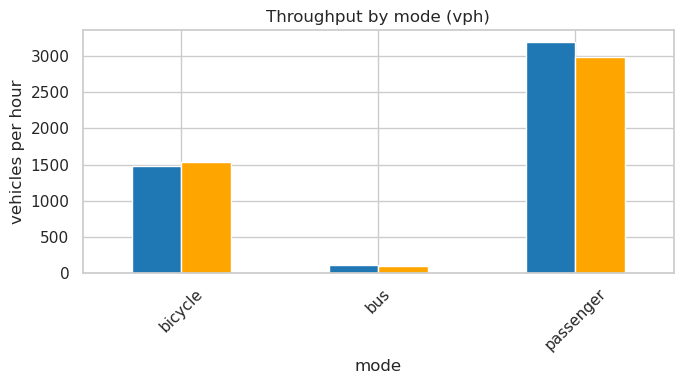

In [32]:
# global throughput: total_vph
df_tp = compare_scalar('throughput/total_vph', 'throughput/total_vph', 'vph')
plot_comparison(df_tp, 'Global throughput (vph): original vs proposal', 'vehicles per hour', 'global_throughput_vph.png')

# per-mode throughput (vph)
modes_tp = per_mode_df('throughput', 'vph')
plot_comparison(modes_tp, 'Throughput by mode (vph)', 'vehicles per hour', 'per_mode_throughput_vph.png', rotate_xticks=True, figsize=(7,4))

## 6) Stop Rate (global and per-mode)

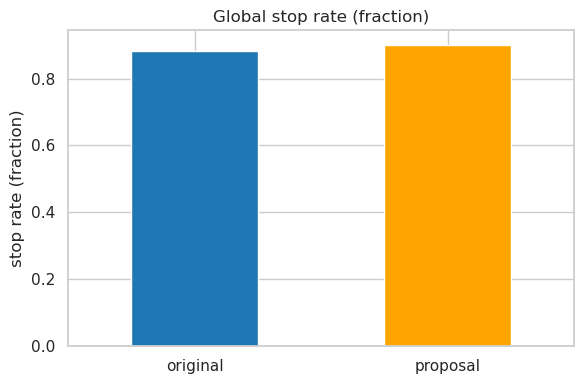

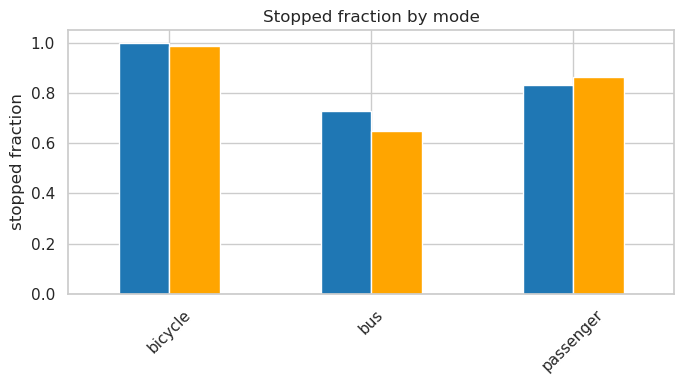

In [33]:
# global stop rate fraction
df_stop = compare_scalar('stops/stop_rate_fraction', 'stops/stop_rate_fraction', 'stop_rate_fraction')
plot_comparison(df_stop, 'Global stop rate (fraction)', 'stop rate (fraction)', 'global_stop_rate.png')

# per-mode stopped_fraction (note keys differ: 'stopped_fraction')
modes_stop = pd.DataFrame({
    'original': [kpi_orig['stops']['per_mode'].get(m, {}).get('stopped_fraction') for m in sorted(kpi_orig['stops']['per_mode'].keys())],
    'proposal': [kpi_prop['stops']['per_mode'].get(m, {}).get('stopped_fraction') for m in sorted(kpi_prop['stops']['per_mode'].keys())],
}, index=sorted(set(list(kpi_orig['stops']['per_mode'].keys()) + list(kpi_prop['stops']['per_mode'].keys()))))
plot_comparison(modes_stop, 'Stopped fraction by mode', 'stopped fraction', 'per_mode_stopped_fraction.png', rotate_xticks=True, figsize=(7,4))

## 7) Emissions (global CO2 and per-mode CO2)

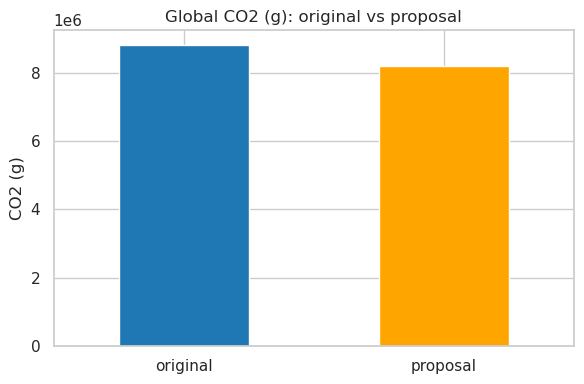

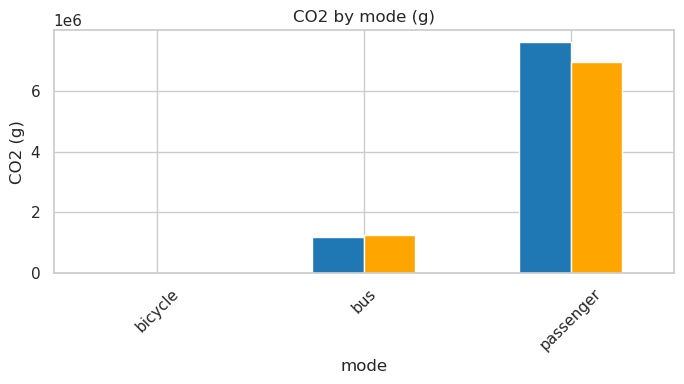

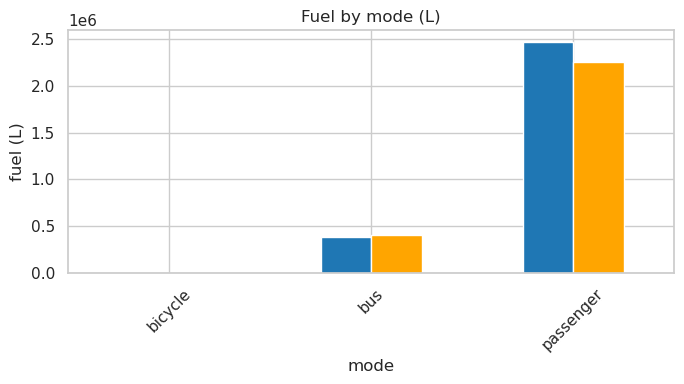

In [34]:
# global CO2
df_co2 = compare_scalar('emissions/total_co2_g', 'emissions/total_co2_g', 'total_co2_g')
plot_comparison(df_co2, 'Global CO2 (g): original vs proposal', 'CO2 (g)', 'global_co2.png')

# per-mode CO2
modes_co2 = per_mode_df('emissions', 'co2')
plot_comparison(modes_co2, 'CO2 by mode (g)', 'CO2 (g)', 'per_mode_co2.png', rotate_xticks=True, figsize=(7,4))

# optionally, per-mode fuel
modes_fuel = per_mode_df('emissions', 'fuel')
plot_comparison(modes_fuel, 'Fuel by mode (L)', 'fuel (L)', 'per_mode_fuel.png', rotate_xticks=True, figsize=(7,4))

### Notes
- The code assumes the KPI JSON structure matches the existing files in `SUMO-UseCase/`.
- If a per-mode entry is missing in either file, `None` will be shown; you may wish to filter/clean those before plotting.
- Plots are saved to `SUMO-UseCase/plots/` relative to the notebook location.